# Starbucks Capstone Challenge
# 3. Modeling: Uplift

Uplift model to predict which persons target in the campaign, using [pylift](https://github.com/wayfair/pylift)

## Dependencies
Libraries needed in this notebook for uplift model

In [1]:
import sys
import pandas as pd
import numpy as np

from pylift import TransformedOutcome
from pylift.eval import UpliftEval

import shap

sys.path.append('..')
from starbucks_campaigns_analytics import read_complete_starbucks_data
from starbucks_campaigns_analytics.constants import PATH_DATA, RANDOM_STATE, MIN_VALUE_TRANSACTION

## Gather data

In [2]:
# Read Starbucks data using the helper function 
# defined in starbucks_campaigns_analytics module
df = read_complete_starbucks_data()
df.head()

,person,event,time,offer_id,amount,reward_expected,gender,age,income,days_since_became_member,profile_group,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,100000.0,443,0,5.0,5.0,168.0,bogo,1.0,1.0,1.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,100000.0,443,0,5.0,5.0,168.0,bogo,1.0,1.0,1.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,NaN,F,75,100000.0,443,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,F,75,100000.0,443,0,5.0,5.0,168.0,bogo,1.0,1.0,1.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,NaN,F,75,100000.0,443,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data preparation for model: Target variables
Uplift models predict incremental value, or lift:
\begin{align*}\text{Lift} = P(\text{buy} | \text{treatment} ) - P(\text{buy} | \text{no treatment} ),\end{align*}

as opposed to outcome models, which simply predict the outcome:
\begin{align*}\text{Outcome} = P(\text{buy} | \text{treatment} ).\end{align*}

Uplift models require two pieces of information (two target variables) for each person: a treatment label (*treatment*) and an outcome label (*converted*).

We are going to use the first campaign (offers launched in t=0) as a dataset sample to train and test our model, so we have to construct previously mention target columns for this temporal window.

In [3]:
# Keep only the first 240 hours of the dataframe 
# (enough time to complete any t=0 offer)
df_window_no_sorted = df[df['time'] <= 240]
df_window = df_window_no_sorted.sort_values('time').copy()

#### 1st campaign (launched at t=0) information
And first target variable (*treatment*) that is True if the person has seen the 1st campaign offer.

In [4]:
# Campaign 0 offer
# New column with the id of the offer the person received in t=0
df_window['t0_offer_id'] = df_window.loc[((df['event'] == 'offer received') 
                                          & (df['time'] == 0)), 'offer_id']
# Extend offer received in t=0 to all transactions of the person
df_window['t0_offer_id'] = df_window.groupby('person')['t0_offer_id'].transform('first')

# target (treatment) -> people who viewed the offer received in t0
df_window['treatment'] = ((df_window['event'] == 'offer viewed') 
                          & (df_window['offer_id'] == df_window['t0_offer_id']))

# New column with the offer completed information 
# (it only takes in acount the completion of the t=0 offer)
df_window['t0_offer_completed'] = ((df_window['event'] == 'offer completed') 
                                   & (df_window['offer_id'] == df_window['t0_offer_id']))

#### 2nd campaign (launched at t=168) information
To be able to know if a transaction is after the 2nd campaign offer visualization

In [5]:
# Campaign 1 offer to be able to
df_window['t168_offer_id'] = df_window.loc[((df['event'] == 'offer received') 
                                          & (df['time'] == 168)), 'offer_id']
# Extend offer received in t=168 to all transactions of the person
df_window['t168_offer_id'] = df_window.groupby('person')['t168_offer_id'].transform('first')

df_window['t168_offer_viewed_time'] = df_window.loc[((df_window['event'] == 'offer viewed') 
                                  & (df_window['offer_id'] == df_window['t168_offer_id'])), 'time']
# Extend offer in t=168 viewed time to all transactions of the person
df_window['t168_offer_viewed_time'] = df_window.groupby('person')['t168_offer_viewed_time'].transform('first')

In [6]:
# Dirty tricks (candidates to refactor)
# Use 500 hours (time out of the window) as 2nd offer viewed time. It is useful in two cases:
# 1. To fill NaN for the comparison (transaction before seeing 2nd campaign offer)
df_window['t168_offer_viewed_time'].fillna(500, inplace=True)
# 2. For the case the 2nd campaign offer is the same as 1st campaign offer
df_window.loc[df_window['t0_offer_id'] == df_window['t168_offer_id'], 't168_offer_viewed_time'] = 500

#### Second target variable
(*converted*) that is True if the person has completed the 1st campaign offer or has a transaction of more than \\$10 after viewing the offer (and before viewing the 2nd campaign offer)

In [7]:
# New boolean column -> True for any transaction grater than threshold
# during campaign 0 (before viewing t168 offer)
df_window['transaction_grater_than_threshold_bool'] = (
    (df_window['event'] == 'transaction')
    & (df_window['amount'] >= MIN_VALUE_TRANSACTION)
    & (df_window['time'] < df_window['t168_offer_viewed_time'])
)

# target (converted) -> people who completed an offer or whose transactions are grater than threshold 
df_window['converted'] = ((df_window['transaction_grater_than_threshold_bool']) 
                          | (df_window['t0_offer_completed']))

## Data preparation for model: Column selection and dummy variables

In [8]:
# Column list for the model
selected_columns = ['person', 'treatment', 'converted','age', 'income', 
                    'reward', 'difficulty', 'web', 
                    'email', 'mobile', 'social', 'offer_type',
                    'gender']

In [9]:
# For the model we only keep a row per person
df_pylift = (
    df_window[selected_columns]
    .groupby('person')
    .agg({'treatment': 'any',
          'converted': 'any',
          'age': 'first',
          'income': 'first',
          'reward': 'first',
          'difficulty': 'first',
          'web': 'first',
          'email': 'first',
          'mobile': 'first',
          'social': 'first',
          'offer_type': 'first',
          'gender': 'first'
         })
    .reset_index()
)

In [10]:
# Fillna

df_pylift['offer_type'].fillna('none', inplace=True)
df_pylift['reward'].fillna(0, inplace=True)
df_pylift['difficulty'].fillna(0, inplace=True)
df_pylift['web'].fillna(0, inplace=True)
df_pylift['email'].fillna(0, inplace=True)
df_pylift['mobile'].fillna(0, inplace=True)
df_pylift['social'].fillna(0, inplace=True)

In [11]:
# Dummy variables

# offer_type
df_pylift = (
    df_pylift
    .join(pd.get_dummies(df_pylift['offer_type'], prefix='offer_type'))
    .drop(columns='offer_type')
)

# gender
df_pylift = (
    df_pylift
    .join(pd.get_dummies(df_pylift['gender'], prefix='gender'))
    .drop(columns='gender')
)

### Groups sizes validation

In [12]:
# Target groups sizes for the model
df_pylift.groupby(['treatment', 'converted']).size()

treatment  converted
False      False        3557
           True         2275
True       False        3288
           True         5409
dtype: int64

## Uplift model

In [13]:
# Pylift model
up = TransformedOutcome(df_pylift.drop(columns=['person']),
                        random_state=RANDOM_STATE,
                        col_treatment='treatment',
                        col_outcome='converted')

#### Grid search params

In [14]:
grid_search_params = {
    'param_grid': {'n_estimators': [100, 300],
                   'colsample_bytree': [0.9, 1],
                   'colsample_bylevel': [0.9, 1],
                   'max_depth': [3, 5]},
    'verbose': True,
    'n_jobs': -1,
}
up.grid_search(**grid_search_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=True,
                                    subsample=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bylevel': [0.9, 1],
                         'colsample_bytree': [0.9, 1], 'max_depth': [3, 5],
                         'n_estimators': [100, 300]},
             pre_dispatch='2*n_jobs', 

#### Train model with best params

In [15]:
# Pylift model train
up.fit(**up.grid_search_.best_params_)

## Uplift model results: visualizations

### Adjusted Qini curve

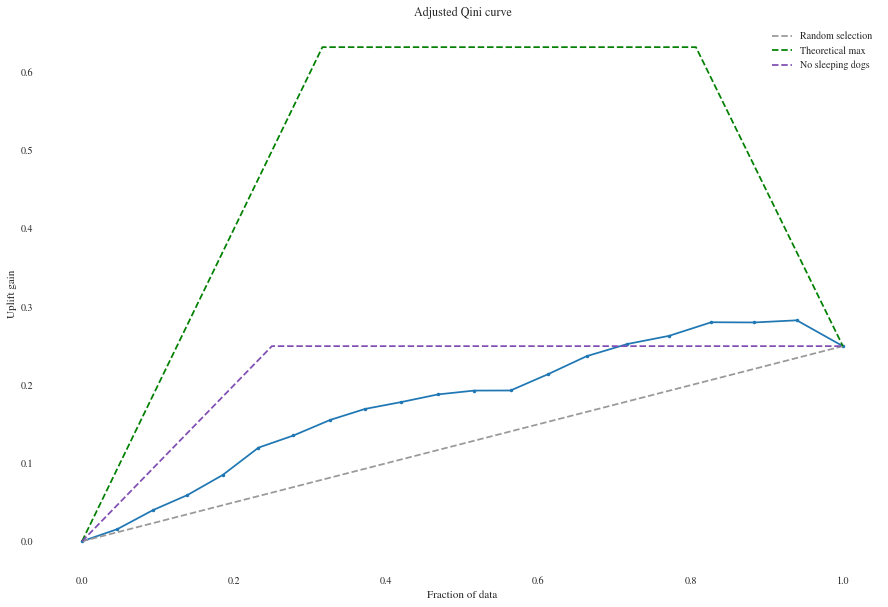

In [16]:
up.plot(plot_type='aqini', show_theoretical_max=True, show_no_dogs=True)

In [17]:
print(up.test_results_.Q_aqini)

0.048877316477666605


### Cumulative gain chart

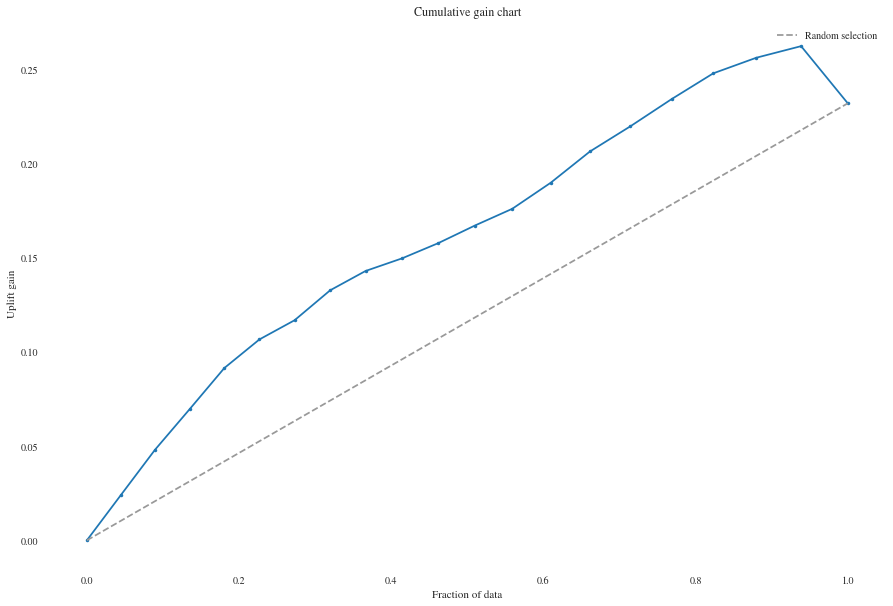

In [18]:
upev = UpliftEval(df_pylift['treatment'],
                  df_pylift['converted'],
                  up.model.predict(df_pylift.drop(columns=['person', 'treatment', 'converted'])),
                  n_bins=20)
upev.plot()

## Uplift model results: features

### Feature importances

In [19]:
X = df_pylift.drop(columns=['person', 'treatment', 'converted'])

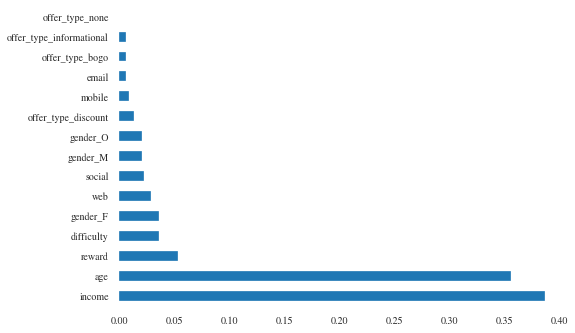

In [20]:
feat_importances = pd.Series(up.model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### SHAP explainer
[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model.

![shap](../reports/images/shap.png)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


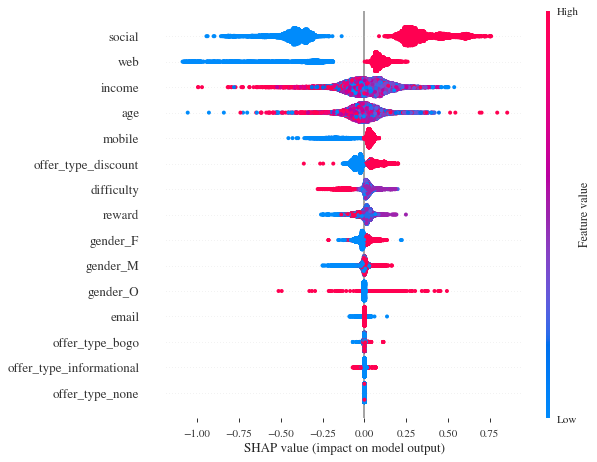

In [21]:
explainer = shap.TreeExplainer(up.model)
shap_values = explainer.shap_values(X)
# summarize the effects of all the features
shap.summary_plot(shap_values, X)